In [2]:
import os
import datetime as dt
import pandas as pd
import csv

In [3]:
# add the 'src' directory as one where we can import modules
import sys
import pathlib # __file__ isn't recognized in Jupyter, so we need this to get the root path
path = pathlib.Path.cwd()
PROJ_ROOT = path.parent 
src_dir = str(PROJ_ROOT / 'src')
PROJ_ROOT = str(PROJ_ROOT)
sys.path.append(src_dir)
# from data import make_dataset

In [4]:
from data import user_df_setup

interim_data_file_path = os.path.join(PROJ_ROOT,
                                 "data",
                                 "interim",
                                 "full_users_df.pkl")
users_df = pd.read_pickle(interim_data_file_path)
raw_data_file_path = os.path.join(PROJ_ROOT,
                             "data",
                             "raw",
                             "users_df.pkl")
raw_users_df = pd.read_pickle(raw_data_file_path)

all_users_df = user_df_setup.user_df_setup(raw_data_file_path, interim_data_file_path)

users_df = all_users_df
# raw_users_df
# raw_users_df[['username', 'timeCreated']].sort_values('timeCreated', ascending = False).head(20)
all_users_df.sort_values('date_created', ascending = False).head(20)
# all_users_df.head(20)

,date_created,refresh_time,userId,unrated_threshold,risky_threshold,supportive_threshold
username,,,,,,
nimaghafari,2018-11-20,NaN,5bf47f7df434f50010c2550e,0.0,1.0,3.0
google,2018-11-20,NaN,5bf47741f434f50010c25507,0.0,1.0,3.0
shanila,2018-11-20,NaN,5bf46c4ff434f50010c25502,0.0,1.0,3.0
jmeow,2018-11-20,NaN,5bf3d03b0760320010e58efe,0.0,1.0,3.0
plush.mary,2018-11-20,NaN,5bf3a4fe0760320010e58ee3,0.0,1.0,3.0
nepthys,2018-11-20,NaN,5bf371bbf434f50010c254d0,0.0,1.0,3.0
philoiz,2018-11-19,NaN,5bf30d1a0760320010e58ec0,0.0,1.0,3.0
upstate518,2018-11-19,NaN,5bf2de44f434f50010c254a3,0.0,1.0,3.0
fenderman123,2018-11-19,NaN,5bf3028cf434f50010c254ad,0.0,1.0,3.0


In [17]:
current_users = all_users_df[all_users_df['date_created'] > (dt.date.today() - dt.timedelta(30))]
user_ids = all_users_df['userId'].tolist()
user_ids

['000000000000000000000000',
 '5aebcb8cc0162e0010966860',
 '5b0d91a3876ddd001af27ccb',
 '5b198f09dfd99a00113eefcd',
 '5b23b05adfd99a00113eefd9',
 '5b26d5de04dd5a001abdcf5a',
 '5b26dba804dd5a001abdcf5d',
 '5b26dd7804dd5a001abdcf62',
 '5b29855504dd5a001abdcf84',
 '5b2b007a04dd5a001abdcf9e',
 '5b2b9cb204dd5a001abdcfa4',
 '5b2b9efc04dd5a001abdcfaa',
 '5b2bd36804dd5a001abdcfc8',
 '5b30f032a58439001a5e49a3',
 '5b33ab0da58439001a5e49e9',
 '5b34d20aa58439001a5e49ef',
 '5b354219a58439001a5e49fb',
 '5b354dada58439001a5e49fe',
 '5b35544fa58439001a5e4a08',
 '5b3682b7a58439001a5e4ab0',
 '5b630a9cb7c059001a4dbad4',
 '5b647ca6d684d6001a2249a6',
 '5b6ef82c78c5fb001a2216f1',
 '5b6f42096d0afc001a8a8f71',
 '5b72d27e6ae794001ab18e56',
 '5b85af6ebef5f7001a6464fc',
 '5b91efc055007d0010817fa0',
 '5b95757fad7027001080b22c',
 '5b97e311ad7027001080b26d',
 '5b97e336ad7027001080b270',
 '5b988229ad7027001080b2b8',
 '5b9f052e3ed631001a47c2de',
 '5ba05e113ed631001a47c354',
 '5ba05fc23ed631001a47c35d',
 '5ba061173ed6

In [27]:
from data import database_query

raw_data_path = os.path.join(PROJ_ROOT,
                             "data",
                             "raw")
current_users_df = all_users_df[all_users_df['date_created'] > (dt.date.today() - dt.timedelta(30))]
user_ids = current_users_df['userId'].tolist()
database_query.make_raw_contacts_df(database_query.mongo_connect(),
                                   raw_data_path,
                                   user_ids)

In [28]:
from data import contacts_df_setup

interim_data_path = os.path.join(PROJ_ROOT,
                                 "data",
                                 "interim")
contacts_dict = {}

usernames = current_users.index
for username in usernames: 
    interim_contact_data_file_path = os.path.join(interim_data_path, 'contacts_df_' + username + '.pkl')
    if os.path.isfile(interim_contact_data_file_path):
        contacts_df = pd.read_pickle(interim_contact_data_file_path)
    else:
        contacts_df = contacts_df_setup.contacts_df_setup(username,
                                                          current_users_df,
                                                          raw_data_path,
                                                          interim_data_path)
    contacts_dict[username] = contacts_df

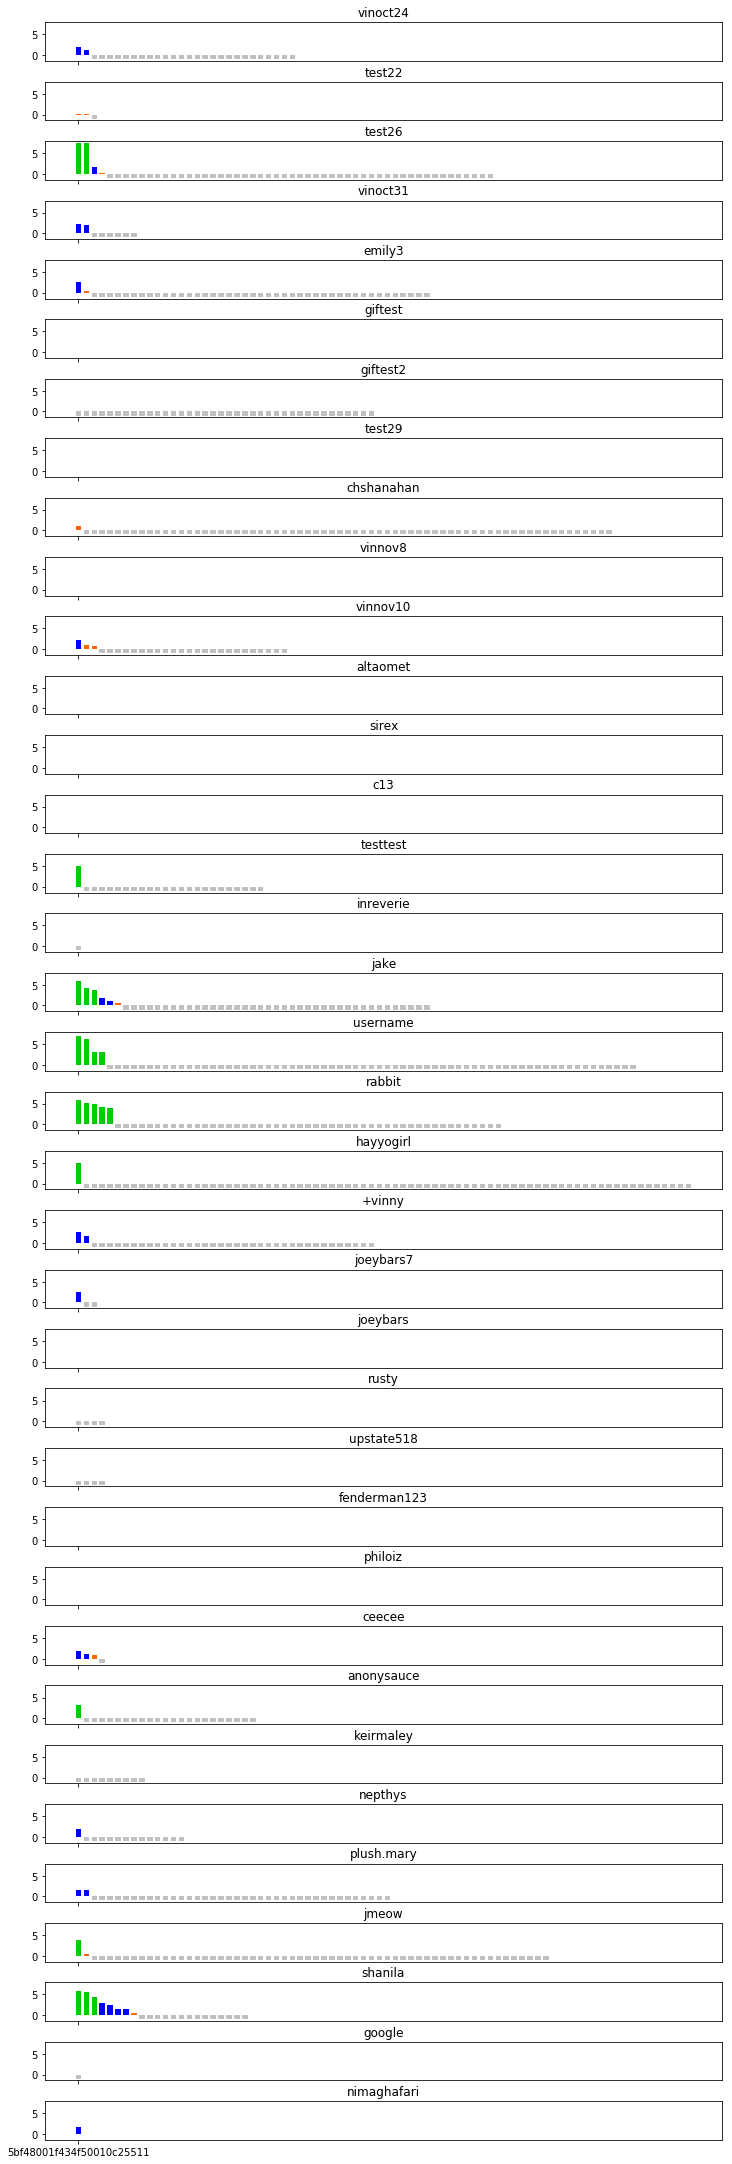

In [31]:
import matplotlib.pyplot as plt

f, axarr = plt.subplots(len(usernames),figsize=(10,30), sharex = True, sharey = True)
plt.tight_layout()

for count, e in enumerate(usernames):  
    unrated_threshold = users_df.loc[e, 'unrated_threshold']
    risky_threshold = users_df.loc[e, 'risky_threshold']
    supportive_threshold = users_df.loc[e, 'supportive_threshold']
    
    contacts_df = contacts_dict[e].sort_values('score', ascending = False)
    unrated = contacts_df['score'][contacts_df['score'] < unrated_threshold]
    risky = contacts_df['score'][(contacts_df['score'] >= unrated_threshold)
                                                     & (contacts_df['score'] <= risky_threshold)]
    neutral = contacts_df['score'][(contacts_df['score'] > risky_threshold)
                                                     & (contacts_df['score'] < supportive_threshold)]
    supportive = contacts_df['score'][(contacts_df['score'] >= supportive_threshold)]
    
    axarr[count].bar(supportive.index, supportive, 0.7, color = '#00cc00')
    axarr[count].bar(neutral.index, neutral, 0.7, color = 'b')
    axarr[count].bar(risky.index, risky, 0.7, color = '#ff6600')
    axarr[count].bar(unrated.index, unrated, 0.7, color = '#C0C0C0')
    axarr[count].set_title(e)
plt.show()